# Generating MNIST

In [1]:
import os
import sys
import time
import random
import tempfile
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from scipy.special import softmax
from torchvision import datasets, transforms
from torch.distributions import MultivariateNormal

## Load Data

In [2]:
batch_size=1000
dim = 784  # 28x28

### Target Distribution:

We want to generate samples from the distribution of MNIST images

In [3]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(tempfile.gettempdir(), train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])),
        batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

### Base distribution:

We use the factorized distribution multivariate normal with diagonal covariance matrix.

In [4]:
base_distr = MultivariateNormal(torch.zeros(dim), torch.eye(dim))

## Define flows

In [5]:
class MLP(nn.Module):
    def __init__(self, dim, hidden_size=[], activation=F.relu):
        super(MLP, self).__init__()
        self.activation = activation
        units = [dim] + hidden_size + [dim]
        self.layers = nn.ModuleList([nn.Linear(units[i], units[i+1])
                                     for i in range(len(units)-1)])

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        y = self.layers[-1](x)

        return y

In [6]:
class AffineConstantLayer(nn.Module):

    def __init__(self, dim, scale=True, shift=True):
        super(AffineConstantLayer, self).__init__()

        self.s = nn.Parameter(torch.randn(1, dim, requires_grad=True)) \
            if scale else None
        self.t = nn.Parameter(torch.randn(1, dim, requires_grad=True)) \
            if shift else None

    def forward(self, x):
        s = self.s if self.s is not None else x.new_zeros(x.size())
        t = self.t if self.t is not None else x.new_zeros(x.size())
        z = x * torch.exp(s) + t
        log_det = torch.sum(s, dim=1)
        return z, log_det

    def backward(self, z):
        s = self.s if self.s is not None else z.new_zeros(z.size())
        t = self.t if self.t is not None else z.new_zeros(z.size())
        x = (z - t) * torch.exp(-s)
        log_det = torch.sum(-s, dim=1)
        return x, log_det

In [7]:
class NvpCouplingLayer(nn.Module):
    def __init__(self, dim, hidden_size=[1000, 1000], random_mask=True):
        super(NvpCouplingLayer, self).__init__()
        self.s = MLP(dim, hidden_size)
        self.t = MLP(dim, hidden_size)
        
        # Use random partitioning of the data
        mask = np.random.randint(2, size=dim)
        if random_mask:
            while mask.sum() < 1 or mask.sum() == dim:
                mask = np.random.randint(2, size=dim)
        else:
            mask = np.zeros((1, dim))
            mask[dim//2:] = 1
            
        self.mask = nn.Parameter(
                torch.as_tensor(mask.copy(), dtype=torch.float),
                requires_grad=False)

    def forward(self, x):
        x_b = self.mask*x
        b_1 = 1 - self.mask

        s, t = self.s(x_b), self.t(x_b)
        y = x_b + b_1 * (x * torch.exp(s) + t)

        log_det = torch.sum(b_1*s, dim=1)

        return y.flip((1,)), log_det.squeeze()

    def backward(self, x):
        x_b = self.mask*x
        b_1 = 1 - self.mask

        s, t = self.s(x_b), self.t(x_b)
        y = x_b + b_1*((x - t) * torch.exp(-s))

        log_det = torch.sum(b_1*(-s), dim=1)

        return y.flip((1,)), log_det.squeeze()

In [8]:
class Flow(nn.Module):
    def __init__(self, layers, **kwargs):
        super(Flow, self).__init__()

        self.layers = nn.ModuleList(layers)
        self.log_det = nn.Parameter(torch.zeros(1), requires_grad=False)

    def forward(self, x):
        cum_log_det = self.log_det.new_full((x.shape[0],), fill_value=0)
        for layer in self.layers:
            x, log_det = layer(x)
            cum_log_det += log_det
            
        return x, cum_log_det
            
    def backward(self, x):
        cum_log_det = self.log_det.new_full((x.shape[0],), fill_value=0)
        for layer in self.layers[::-1]:
            x, log_det = layer.backward(x)
            cum_log_det += log_det

        return x, cum_log_det

## Create flows

In [9]:
# Values of gamma to use
gammas = [
#     lambda x: 0.,
#     lambda x: 1.,
#     lambda x: 0.,
    lambda x: 1.,
]

devices = [
#     torch.device('cuda:1'),
#     torch.device('cuda:1'),
#     torch.device('cuda:1'),
    torch.device('cuda:1')
]

flows = [
#     Flow(layers=[AffineConstantLayer(dim) for _ in range(20)]),
#     Flow(layers=[AffineConstantLayer(dim) for _ in range(20)]),
#     Flow(layers=[NvpCouplingLayer(dim, [1000], random_mask=False) for _ in range(20)]),
    Flow(layers=[NvpCouplingLayer(dim, [1000, 1000], random_mask=False) for _ in range(20)]),
]

labels = [
#     r'$\mathrm{AffineFlow}, \gamma = 0$',
#     r'$\mathrm{AffineFlow}, \gamma = 1$',
#     r'$\mathrm{NvpFlow}, \gamma = 0$',
    r'$\mathrm{NvpFlow}, \gamma = 1$',
]

## Train Flows:

We train Flows using the forward KL method:

In [10]:
epochs = 500

In [11]:
def train_model(gamma, model, dev):
    
    base_distr = MultivariateNormal(torch.zeros(dim).to(dev, non_blocking=True), torch.eye(dim).to(dev, non_blocking=True))
    model = model.to(dev, non_blocking=True)
    
    # Instantiate optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters())
    
    loss = []
    logprior = []
    logdet = []
    
    # Train loop
    t0 = time.time()
    for e in range(epochs):
        
        cum_loss = torch.zeros(1, device=dev)
        cum_logdet = torch.zeros(1, device=dev)
        cum_logprior = torch.zeros(1, device=dev)
        
        _gamma = gamma(e)
        for images, _ in train_loader:
            images = images.view(images.shape[0], -1)
            
            images = images.to(dev, non_blocking=True)
            
            optimizer.zero_grad()
            
            preds, _logdet = model.backward(images)

            _logdet = torch.mean(_logdet)
            _logprior = -torch.mean(base_distr.log_prob(preds))
            _loss = _logprior - _gamma*_logdet
            
            
            cum_loss += _loss
            cum_logprior += _logprior
            cum_logdet += _logdet
            
            _loss.backward()
            optimizer.step()
            
        loss.append(cum_loss.item()/len(train_loader.dataset))
        logprior.append(cum_logprior.item()/len(train_loader.dataset))
        logdet.append(cum_logdet.item()/len(train_loader.dataset))
            
        if e%10 == 9:
            print('epoch: {}, at time: {:.2f}, loss: {:.3f}'.format(e, time.time()-t0, loss[-1]))
        
        
    return {
        'model': model.to('cpu'),
        'loss': loss,
        'logprior': logprior,
        'logdet': logdet,
    }

In [12]:
models = [train_model(gamma, flow, dev) for gamma, flow, dev in zip(gammas, flows, devices)]

epoch: 9, at time: 226.19, loss: -1.010
epoch: 19, at time: 454.23, loss: -1.110
epoch: 29, at time: 681.02, loss: -1.121
epoch: 39, at time: 907.84, loss: -1.141
epoch: 49, at time: 1134.63, loss: -1.109
epoch: 59, at time: 1361.45, loss: -0.962
epoch: 69, at time: 1589.11, loss: -1.070
epoch: 79, at time: 1816.65, loss: -1.117
epoch: 89, at time: 2043.36, loss: -1.107
epoch: 99, at time: 2270.44, loss: -1.114
epoch: 109, at time: 2497.43, loss: -1.079
epoch: 119, at time: 2724.85, loss: -1.186
epoch: 129, at time: 2952.86, loss: -1.201
epoch: 139, at time: 3180.83, loss: -1.149
epoch: 149, at time: 3409.10, loss: -1.170
epoch: 159, at time: 3637.07, loss: -1.165
epoch: 169, at time: 3863.83, loss: -1.153
epoch: 179, at time: 4091.25, loss: -1.169
epoch: 189, at time: 4318.19, loss: -1.224
epoch: 199, at time: 4546.52, loss: -1.188
epoch: 209, at time: 4774.72, loss: -1.219
epoch: 219, at time: 5001.83, loss: -1.169
epoch: 229, at time: 5229.94, loss: -1.220
epoch: 239, at time: 5460.

C:\Users\sergi\Anaconda3\envs\calibration\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  


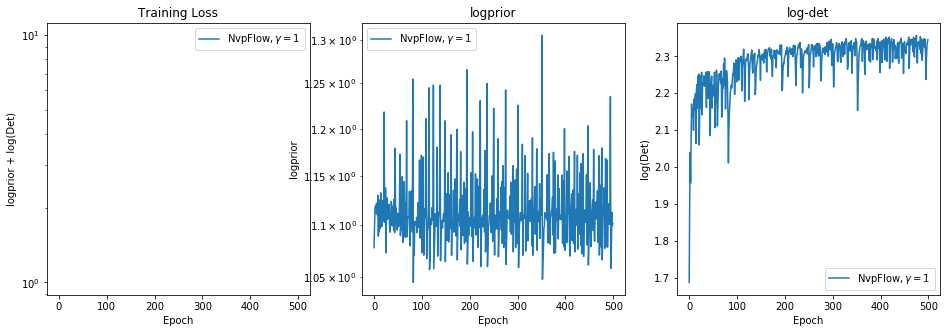

In [13]:
# Plot training NLL
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

for i, model in enumerate(models):
    label = labels[i]
    ax[0].plot(model['loss'], label=label)
    ax[1].plot(model['logprior'], label=label)
    ax[2].plot(model['logdet'], label=label)


ax[0].set_title('Training Loss')
ax[0].set_ylabel('logprior + log(Det)')
ax[0].set_xlabel('Epoch')
ax[0].set_yscale('log')
ax[0].legend()

ax[1].set_title('logprior')
ax[1].set_ylabel('logprior')
ax[1].set_xlabel('Epoch')
ax[1].set_yscale('log')
ax[1].legend()

ax[2].set_title('log-det')
ax[2].set_ylabel('log(Det)')
ax[2].set_xlabel('Epoch')
ax[2].legend()

plt.show()

## Visualize results:

In [14]:
x = base_distr.sample((16,))

In [15]:
x.shape

torch.Size([16, 784])

In [16]:
z, _ = models[0]['model'](x)

z = z.view(-1, 28, 28).detach().numpy()

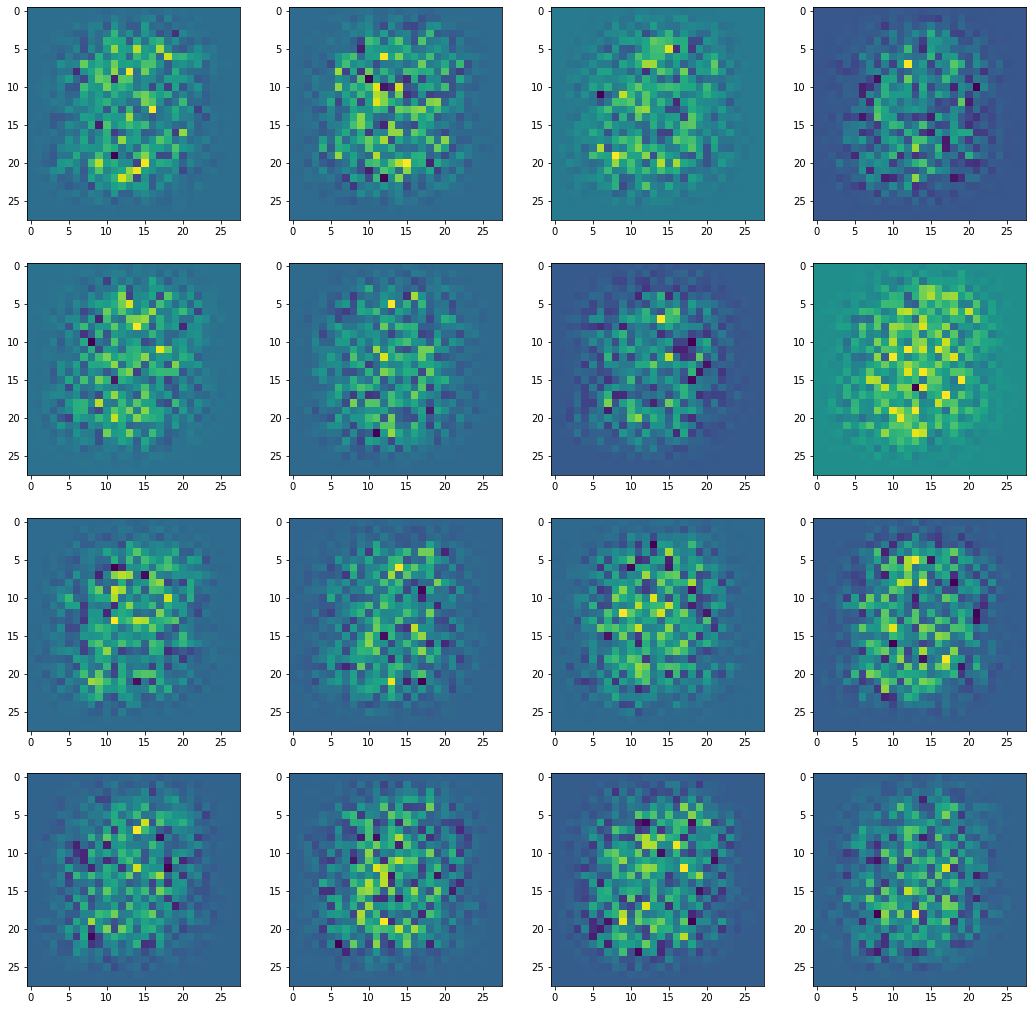

In [17]:
fig, ax_arr = plt.subplots(4, 4, figsize=(18, 18))

for i, ima in enumerate(z):
    ax_arr[i%4, i//4].imshow(z[i, :])
    
plt.show()

In [18]:
z[0]

array([[ 2.58127402e-05, -1.07510714e-05,  2.98257000e-05,
        -4.90071252e-05,  7.15840608e-04,  1.79275870e-04,
         3.29270959e-03, -8.23932886e-03,  8.89389217e-03,
        -2.41912752e-02, -6.81241602e-02, -5.17780334e-03,
         1.07777715e-02,  3.84653360e-03, -1.04267895e-03,
         4.20876294e-02, -3.31996232e-02, -1.29083842e-02,
         2.67864764e-02, -3.21692228e-03,  2.02229023e-02,
         4.16721404e-03, -5.51071763e-03,  1.24141201e-03,
         1.08767068e-04,  1.61756761e-05,  1.14555529e-04,
        -1.38999545e-04],
       [-1.35550625e-04,  2.35705520e-05, -3.60079110e-04,
         5.32709062e-04,  1.58680230e-03,  9.63859260e-03,
        -4.34853137e-03, -1.99779123e-03, -6.26346469e-03,
         4.03800234e-02, -2.22695768e-02,  1.64033979e-01,
         2.92596668e-02, -3.74628454e-02,  3.34560722e-02,
         1.50151536e-01,  1.97408393e-01, -1.52766809e-01,
         1.87154949e-01, -7.09493756e-02,  3.20383906e-03,
        -1.91705003e-02,  2.80